#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
    V_rho=np.zeros(Irho_.shape)
    np.fill_diagonal(V_rho, vessel_inertia)
    cum_m=0
    cum_i=0
    fin_123=[]
    for i in range(node_N-1,-1,-1):
        cum_m+=Ws[i]*cum_d_inv[i]**2
        cum_i+=Irho_
        fin_123.append(V_rho+cum_m + cum_i)
    return np.array(fin_123[::-1])

In [16]:
lll = [100 for i in range(node_N)]

In [17]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [18]:
cum_d_inv

[5000,
 4900,
 4800,
 4700,
 4600,
 4500,
 4400,
 4300,
 4200,
 4100,
 4000,
 3900,
 3800,
 3700,
 3600,
 3500,
 3400,
 3300,
 3200,
 3100,
 3000,
 2900,
 2800,
 2700,
 2600,
 2500,
 2400,
 2300,
 2200,
 2100,
 2000,
 1900,
 1800,
 1700,
 1600,
 1500,
 1400,
 1300,
 1200,
 1100,
 1000,
 900,
 800,
 700,
 600,
 500,
 400,
 300,
 200,
 100,
 10]

In [19]:
Ws = np.array(mi)*9.81

In [20]:
Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [21]:
# Irho+=vessel_inertia

In [22]:
Irho[-1][0][0]

60761404731.24999

In [23]:
Irho[-49][0][0]

441458471931.25

In [24]:
Irho

array([[[4.65002472e+11, 4.04250480e+11, 4.04250480e+11],
        [4.04250480e+11, 4.65002472e+11, 4.04250480e+11],
        [4.04250480e+11, 4.04250480e+11, 4.65002477e+11]],

       [[4.41458472e+11, 3.80706480e+11, 3.80706480e+11],
        [3.80706480e+11, 4.41458472e+11, 3.80706480e+11],
        [3.80706480e+11, 3.80706480e+11, 4.41458477e+11]],

       [[4.18846814e+11, 3.58094822e+11, 3.58094822e+11],
        [3.58094822e+11, 4.18846814e+11, 3.58094822e+11],
        [3.58094822e+11, 3.58094822e+11, 4.18846819e+11]],

       [[3.97148664e+11, 3.36396672e+11, 3.36396672e+11],
        [3.36396672e+11, 3.97148664e+11, 3.36396672e+11],
        [3.36396672e+11, 3.36396672e+11, 3.97148668e+11]],

       [[3.76345185e+11, 3.15593194e+11, 3.15593194e+11],
        [3.15593194e+11, 3.76345185e+11, 3.15593194e+11],
        [3.15593194e+11, 3.15593194e+11, 3.76345190e+11]],

       [[3.56417544e+11, 2.95665552e+11, 2.95665552e+11],
        [2.95665552e+11, 3.56417544e+11, 2.95665552e+11],
    

In [25]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [26]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [27]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [28]:
E = 210e9

In [29]:
E*Ar/1e10

1.6991625880187402

In [30]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [31]:
DT=np.diag(diag_DT) # (35) in [2]

In [32]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [33]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [34]:
CT=np.diag(diag_CT)

In [35]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [36]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [37]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [38]:
rng = np.random.default_rng()

In [39]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [40]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [41]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.84301305, -0.50342017, -0.18946538],
       [ 0.53784593,  0.78425115,  0.30930873],
       [-0.00712381, -0.36265448,  0.93189644]])

In [42]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.010428


In [43]:
Ret.shape

(50, 3, 3)

In [44]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [45]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [46]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000551


In [47]:
C1(dx,dy,dz,Ret)

array([[ 6.18758109e-01, -1.38272153e+00,  8.74602992e-01,
        -1.45007099e-01, -1.13291473e+00, -6.26365864e-01,
         2.43218524e+00,  2.12668297e-02,  1.95086191e+00,
        -2.04297136e-04, -2.57109136e+00,  6.41163457e-02,
         1.67900236e-01, -2.31357971e+00, -1.86593656e-01,
        -6.28075069e-01,  2.91452654e+00,  1.35575938e-01,
         1.43551518e+00,  1.53631062e+00, -8.67017017e-02,
        -7.85867642e-01,  1.47357097e-02,  1.93504175e-01,
         2.47014906e-02, -6.93809835e-01, -1.30832904e+00,
         6.21902248e+00, -3.88439038e-01,  1.09601020e+00,
        -2.99212201e-01,  4.50616370e-01, -2.68850108e-01,
        -1.02925775e+00, -1.44593788e+00, -9.13122153e-03,
        -2.73262445e+00, -1.51769734e+00,  1.05057410e-02,
         1.16849264e+00, -5.36678823e-06, -7.13602373e-05,
         4.92327001e-01,  7.00147944e-01,  9.70946676e-01,
        -6.20990737e-05, -2.02370993e+00,  1.55100678e+00,
        -5.89323884e-01, -1.92044986e-01],
       [-4.95

In [48]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [49]:
fD(dx,dy,dz,DT,Ret).T

array([[ 3.55107379e+03, -2.84213986e+03,  4.03120613e+03],
       [-7.93548578e+03,  5.62775335e+03,  1.37630856e+04],
       [ 5.01937625e+03, -5.21751052e+03,  4.00765616e+03],
       [-8.32200660e+02, -8.08550638e+02, -4.29545582e+03],
       [-6.50183607e+03,  9.41783852e+03, -2.14704744e+04],
       [-3.59473495e+03, -1.29005318e+03,  3.65256363e+03],
       [ 1.39583937e+04,  5.39949275e+03,  3.14755891e+03],
       [ 1.22051058e+02,  1.60507963e+04,  3.16002834e+03],
       [ 1.11960627e+04, -1.03875702e+04, -1.20042548e+04],
       [-1.17246820e+00, -1.88414746e+04,  2.07518047e+04],
       [-1.47555806e+04,  1.34843750e+03, -1.04426475e+04],
       [ 3.67965884e+02, -7.04775770e+01, -6.65591613e+01],
       [ 9.63585152e+02,  1.25248134e+04, -2.67935572e+04],
       [-1.32777125e+04, -5.52892410e+02,  4.18328952e+02],
       [-1.07086733e+03, -3.46883757e+02, -1.32986029e+04],
       [-3.60454414e+03,  1.13118075e+03, -7.15363529e+03],
       [ 1.67265667e+04, -6.07211042e+03

In [50]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000300


In [51]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [52]:
I=np.identity(3)

In [53]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000377


In [54]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [55]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [56]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [57]:
DR=np.diag(diag_DR) 

In [58]:
Ar

0.08091250419136858

In [59]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [60]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [61]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [62]:
def Re_b(Ret):
    return Ret

In [63]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000149


In [64]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [65]:
phi(x,y,z,Ret,None,None)

array([[ 0.98741981,  0.20896843, -0.91868818],
       [-0.46278585,  0.19966646, -1.94605108],
       [-1.48170592,  0.72166288, -0.40590649],
       [ 0.89446611, -2.22124706, -0.21783917],
       [-1.69124789, -0.1453222 ,  1.30209763],
       [ 0.22855888,  1.02375966,  0.04806936],
       [-1.62994632,  0.87149692, -1.18350478],
       [-1.12450723,  1.69872331,  2.03958864],
       [-0.13295244, -0.4091723 ,  0.78590408],
       [-1.66737067, -0.45984712,  0.15474179],
       [ 0.8390358 ,  0.29187753, -1.8442236 ],
       [-0.72229362,  0.8494427 , -0.97993817],
       [-0.55378809,  1.6135269 , -1.8674338 ],
       [-0.5045823 ,  0.50267457,  2.6473239 ],
       [ 0.90051674, -1.49664466,  1.59065198],
       [-0.56755491,  0.58808531,  0.09659369],
       [ 1.41459206,  1.09095095, -0.49641151],
       [ 1.22339892, -0.6389005 , -2.03108543],
       [-0.91220874,  0.73529518, -0.42966302],
       [-0.29972569,  0.27546896, -1.22027115],
       [ 0.2821764 ,  1.7677289 ,  0.230

In [66]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000304


In [67]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [68]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [69]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001208


In [70]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [71]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001567


In [72]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.89253922, -0.28880414, -0.29746834],
       [-0.42205627, -0.01464064,  0.49754526],
       [-1.20352116,  0.02528247, -0.80719355],
       [ 0.81659207, -2.49005432,  0.5559734 ],
       [ 1.12823818,  0.78430819, -0.50583682],
       [ 0.1526467 , -0.10277892,  0.49471981],
       [-0.55227618, -3.22055285, -0.5420494 ],
       [-0.62645851, -0.22144778, -0.33299979],
       [-0.96328173, -0.23438964, -0.15951781],
       [-0.70392283, -1.07009299, -0.79983193],
       [ 0.24277072, -0.67820034,  0.18422014],
       [ 0.58483402,  0.31441828, -0.03072537],
       [-0.87489043,  0.40873683,  0.56954937],
       [-0.01943057,  0.3071507 ,  0.07535775],
       [ 0.61745349,  1.09764237, -0.83728978],
       [ 0.97822711,  3.22243375, -1.54121402],
       [ 0.8091167 ,  1.82877049,  0.45254868],
       [ 1.48461941,  0.27941806,  0.12816503],
       [ 0.0160438 ,  0.90391368,  0.38843272],
       [ 0.54721809,  0.45238474, -0.63605834],
       [ 1.35413005,  2.55282558, -0.504

In [73]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [74]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [75]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-1.12764533e-05, -2.14569609e-05, -1.12755810e-05,
         2.00338785e-05,  1.44740536e-05, -9.75680540e-06,
        -2.05498114e-05,  3.40861917e-06,  1.19506442e-05,
         6.14582763e-06, -2.13607977e-05, -1.82936258e-05,
        -3.48092589e-05,  2.14462789e-05,  3.08726577e-05,
        -4.91486703e-06, -1.58734658e-05, -1.39217101e-05,
        -1.16494655e-05, -1.49572515e-05, -1.53685046e-05,
        -2.18089594e-06, -1.53327394e-05, -1.33925638e-05,
        -1.77631332e-05, -1.74912359e-05,  4.00345913e-06,
         1.47175335e-05,  1.44453070e-05, -7.86074666e-06,
        -4.89358932e-05, -7.19719556e-06,  1.83499772e-07,
        -3.07504102e-05, -4.45120333e-06,  2.03816531e-05,
        -5.42713553e-06, -4.69348478e-06,  1.10595949e-05,
         1.12126989e-05, -3.13822773e-05,  7.29224100e-06,
        -2.57656094e-05, -2.34196872e-05,  1.23317677e-05,
         5.46665126e-06,  4.34493135e-06, -1.71427121e-05,
         1.61571042e-05, -3.72380468e-06],
       [ 1.90

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.006126


In [77]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [78]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [79]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [80]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [81]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 1.14397736e-06, -5.90889567e-07,  4.60988466e-07,
         2.24229801e-06, -7.91489250e-07, -6.94083269e-07,
         1.48413121e-08, -3.33637929e-06,  1.67356992e-07,
         7.19541312e-07, -2.76746510e-06, -9.48206100e-08,
         1.55078828e-06,  2.14826886e-06,  2.07878240e-06,
         8.41871798e-07, -2.64898772e-07, -3.62127915e-06,
        -1.80382761e-07, -1.28972992e-06,  9.05319984e-07,
        -1.14997253e-06,  1.51258597e-08,  2.44575839e-07,
        -1.61003653e-06, -1.07944193e-06, -2.76444773e-07,
         4.04346617e-07, -4.93680609e-07,  5.13267299e-08,
        -3.50220617e-06,  5.95171107e-07, -1.19387239e-06,
        -3.56627983e-07,  1.92333293e-07,  7.69633089e-07,
         1.37315626e-06,  1.14557780e-06,  2.09909880e-07,
         3.32368842e-07,  2.23880543e-07,  3.59930724e-07,
         2.14812788e-06, -2.93896846e-06,  1.32829420e-06,
         3.70027840e-06, -1.30635529e-07,  7.27184081e-07,
         8.89266320e-07,  4.16376380e-07],
       [ 2.20

In [82]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.55107379e+03,  7.93548578e+03, -5.01937625e+03,
         8.32200660e+02,  6.50183607e+03,  3.59473495e+03,
        -1.39583937e+04, -1.22051058e+02, -1.11960627e+04,
         1.17246820e+00,  1.47555806e+04, -3.67965884e+02,
        -9.63585152e+02,  1.32777125e+04,  1.07086733e+03,
         3.60454414e+03, -1.67265667e+04, -7.78074909e+02,
        -8.23847035e+03, -8.81693876e+03,  4.97584009e+02,
         4.51012107e+03, -8.45687381e+01, -1.11052703e+03,
        -1.41762693e+02,  3.98179819e+03,  7.50854479e+03,
        -3.56911811e+04,  2.22926482e+03, -6.29003973e+03,
         1.71718897e+03, -2.58610264e+03,  1.54293989e+03,
         5.90694515e+03,  8.29828656e+03,  5.24043902e+01,
         1.56826245e+04,  8.71011655e+03, -6.02928042e+01,
        -6.70601892e+03,  3.08001798e-02,  4.09538824e-01,
        -2.82548137e+03, -4.01817281e+03, -5.57229593e+03,
         3.56388691e-01,  1.16141400e+04, -8.90128056e+03,
         3.38214977e+03,  1.10215269e+03],
       [ 2.84

In [84]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.001704


In [85]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-4.35518729e+03, -8.13854950e+03,  1.24937455e+04],
       [ 5.72879485e+03, -1.02899806e+04,  4.56117429e+03],
       [ 1.66655158e+01, -1.68323781e+04,  1.68157125e+04],
       [-6.55730865e+03,  4.25808725e+03,  2.29923451e+03],
       [ 3.67990021e+03, -5.19202351e+03,  1.51211595e+03],
       [ 4.41862352e+03, -9.85307351e+03,  5.43444115e+03],
       [ 6.19154062e+03,  7.27193280e+03, -1.34634858e+04],
       [-5.61241795e+03, -1.06054214e+04,  1.62178506e+04],
       [-3.15282687e+03, -1.06297366e+04,  1.37825698e+04],
       [-4.29209702e+03,  1.93142864e+03,  2.36067697e+03],
       [-6.00781641e+03, -2.16984924e+03,  8.17767767e+03],
       [ 5.64671213e+03, -1.65952407e+04,  1.09485173e+04],
       [-1.64198823e+02, -1.27662716e+04,  1.29304708e+04],
       [ 5.77560456e+03, -1.92868605e+04,  1.35112444e+04],
       [ 2.65806816e+03, -4.86354711e+03,  2.20547363e+03],
       [-3.36998557e+03,  4.57544637e+03, -1.20545406e+03],
       [ 4.09292432e+03,  1.82870672e+02

In [86]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.03803749e+10,  2.11337884e+09, -2.24181281e+09],
       [-1.01848097e+10, -5.62361964e+09,  1.05180939e+08],
       [-1.68279878e+10, -1.22584227e+07,  4.40710976e+06],
       [ 1.84121478e+09,  4.14044331e+09, -2.41687189e+09],
       [-1.35809923e+09,  1.54017922e+08,  3.83392181e+09],
       [-1.14545100e+10, -6.02005136e+09, -1.60142342e+09],
       [ 8.64305991e+09, -4.82042972e+09,  1.37111709e+09],
       [-1.30480927e+10,  3.16976776e+09, -2.44265580e+09],
       [-1.21421891e+10,  1.64039115e+09, -1.51243887e+09],
       [-1.33167093e+09,  1.02900634e+09, -3.26309498e+09],
       [-8.02607744e+09,  1.51608098e+08, -5.85621432e+09],
       [-1.35622797e+10, -2.61374623e+09,  3.03297155e+09],
       [-1.19639691e+10,  9.66512737e+08,  8.02313750e+08],
       [-1.46268664e+10, -1.11560628e+09,  4.66000406e+09],
       [-9.19869097e+08,  1.28560417e+09,  3.94367499e+09],
       [-8.21435341e+07, -1.28759622e+09, -4.65758516e+09],
       [ 2.46673963e+08, -4.02912544e+09

In [87]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000300


In [88]:
Re_b(Ret).shape

(50, 3, 3)

In [89]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [90]:
Irho_e(Ret,Irho)

array([[[ 4.55241401e+11,  2.54958205e+11,  9.75623517e+11],
        [ 2.03165988e+11,  9.11489545e+10,  5.54855154e+11],
        [ 1.25291982e+11,  7.42001334e+08,  1.78761055e+11]],

       [[ 1.05322481e+11, -5.02701712e+10,  3.02219287e+10],
        [ 9.06246069e+11, -3.67180331e+10,  6.79279181e+11],
        [ 2.81364140e+11, -5.51026555e+10,  2.71100674e+11]],

       [[ 3.93356726e+11, -2.94200345e+11,  3.15980573e+11],
        [ 4.41162122e+11, -4.49083309e+11,  4.35808775e+11],
        [-3.52694602e+11,  2.96450207e+11, -3.95040458e+11]],

       [[ 5.95573344e+11, -4.30266177e+11,  7.53180953e+11],
        [ 3.97778792e+10,  2.18937943e+10,  8.43490017e+10],
        [-1.52090789e+11,  5.31032870e+10, -9.95561815e+10]],

       [[-3.14428614e+11,  5.47111027e+11, -1.98782325e+11],
        [ 3.49133402e+11, -6.34143118e+11,  1.33912674e+11],
        [-1.48406209e+11,  1.39186829e+11, -3.78104842e+10]],

       [[ 1.92818325e+11,  6.37703030e+09,  9.11741283e+10],
        [ 5.51

In [91]:
startTime1 = datetime.now()
Irho_e(Ret,Irho)
print(datetime.now() - startTime1)

0:00:00.000870


In [92]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [93]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [94]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [95]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret.astype(np.float32),omega.astype(np.float32))

    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [96]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002854


In [97]:
d_me_

array([[-2.87909981e-15, -5.20311513e-11,  8.44154319e-11],
       [-2.84282170e-15, -1.14061206e-10,  1.61054288e-10],
       [-3.97316142e-15, -1.71958013e-12,  1.80373853e-12],
       [-9.08901522e-16, -5.48236792e-11,  8.59814093e-11],
       [-7.41999683e-16, -2.85232219e-12,  6.11683895e-11],
       [-3.07443819e-15, -1.39363162e-10,  1.80461683e-10],
       [-2.54816477e-15, -8.85518383e-11,  1.47033098e-10],
       [-3.35335766e-15, -1.01995409e-10,  1.23224893e-10],
       [-3.19629455e-15, -4.72502163e-11,  6.87871822e-11],
       [-7.32341156e-16, -3.23601860e-11,  4.26509647e-11],
       [-2.42539893e-15, -1.68752271e-10,  1.01832435e-10],
       [-3.44088088e-15, -1.27118132e-10,  1.10590880e-10],
       [-3.16493017e-15, -4.01341252e-11,  2.34093748e-11],
       [-3.61867790e-15, -1.84328545e-10,  1.68505774e-10],
       [-5.72270635e-16, -3.36519172e-11,  5.20472965e-11],
       [-1.14330778e-16, -1.52629860e-11,  1.43995906e-10],
       [-2.37975640e-16, -6.00395054e-11

In [98]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [99]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.55107379e+03,  7.93548578e+03, -5.01937625e+03,
         8.32200660e+02,  6.50183607e+03,  3.59473495e+03,
        -1.39583937e+04, -1.22051058e+02, -1.11960627e+04,
         1.17246820e+00,  1.47555806e+04, -3.67965884e+02,
        -9.63585152e+02,  1.32777125e+04,  1.07086733e+03,
         3.60454414e+03, -1.67265667e+04, -7.78074909e+02,
        -8.23847035e+03, -8.81693876e+03,  4.97584009e+02,
         4.51012107e+03, -8.45687381e+01, -1.11052703e+03,
        -1.41762693e+02,  3.98179819e+03,  7.50854479e+03,
        -3.56911811e+04,  2.22926482e+03, -6.29003973e+03,
         1.71718897e+03, -2.58610264e+03,  1.54293989e+03,
         5.90694515e+03,  8.29828656e+03,  5.24043902e+01,
         1.56826245e+04,  8.71011655e+03, -6.02928042e+01,
        -6.70601892e+03,  3.08001798e-02,  4.09538824e-01,
        -2.82548137e+03, -4.01817281e+03, -5.57229593e+03,
         3.56388691e-01,  1.16141400e+04, -8.90128056e+03,
         3.38214977e+03,  1.10215269e+03],
       [ 2.84

### Static solution

In [100]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [101]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [102]:
Fx_0=82945396

In [103]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [104]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [105]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [106]:
delta_x=horizontal_length/(node_N-1)

In [107]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [108]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [109]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [110]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [111]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

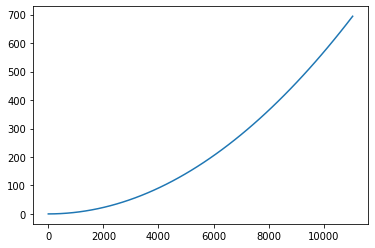

In [112]:
plt.plot(x0, z0)
plt.show()

In [113]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [114]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [115]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1] 
     
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [116]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [117]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [118]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [119]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [120]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [121]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [122]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [123]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

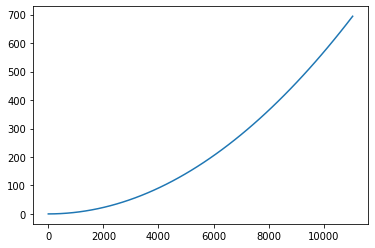

In [124]:
plt.plot(x0_, z0_)
plt.show()

In [219]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==7:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.0022313638346709297*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([1.3587337935216937e-05*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.013664356620045393*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [220]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [221]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [222]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [223]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [224]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

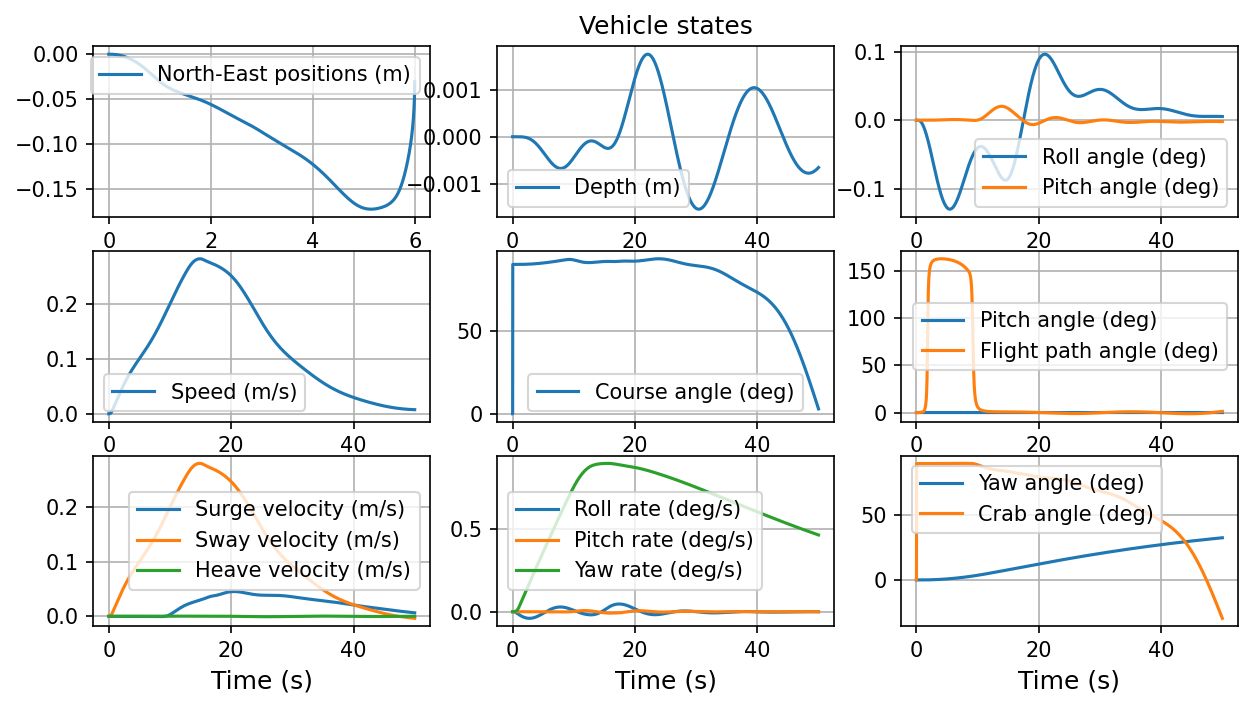

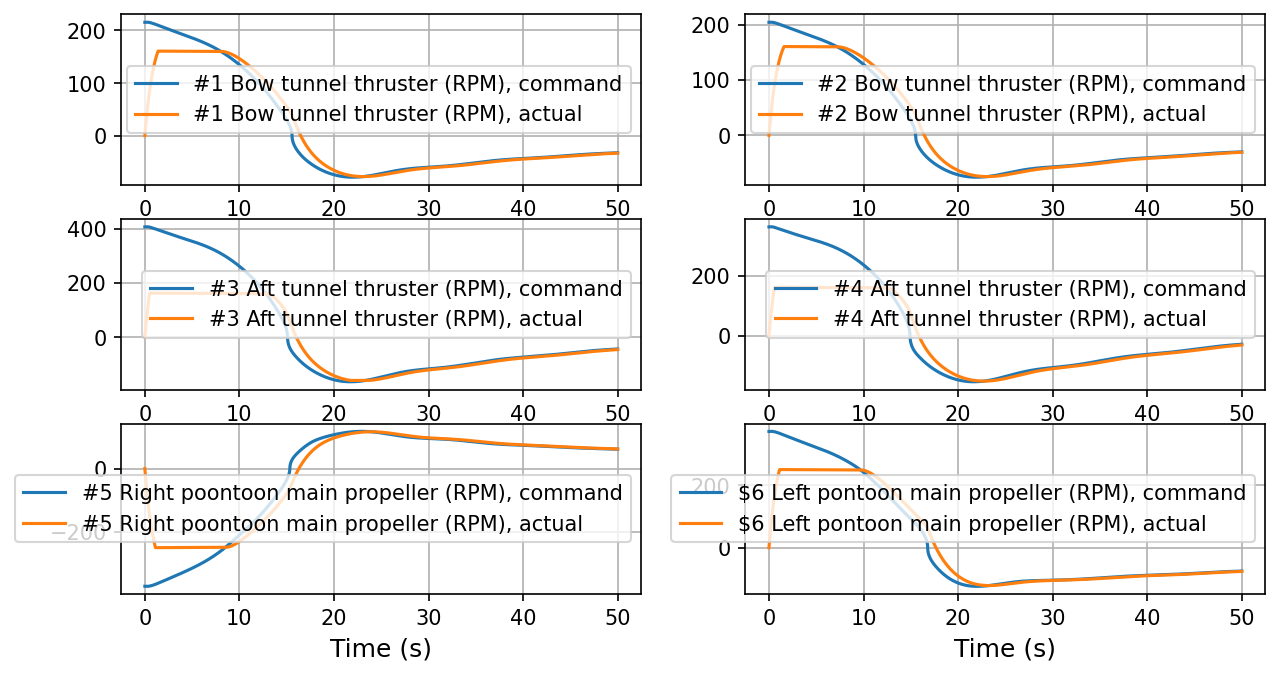

In [225]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [226]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

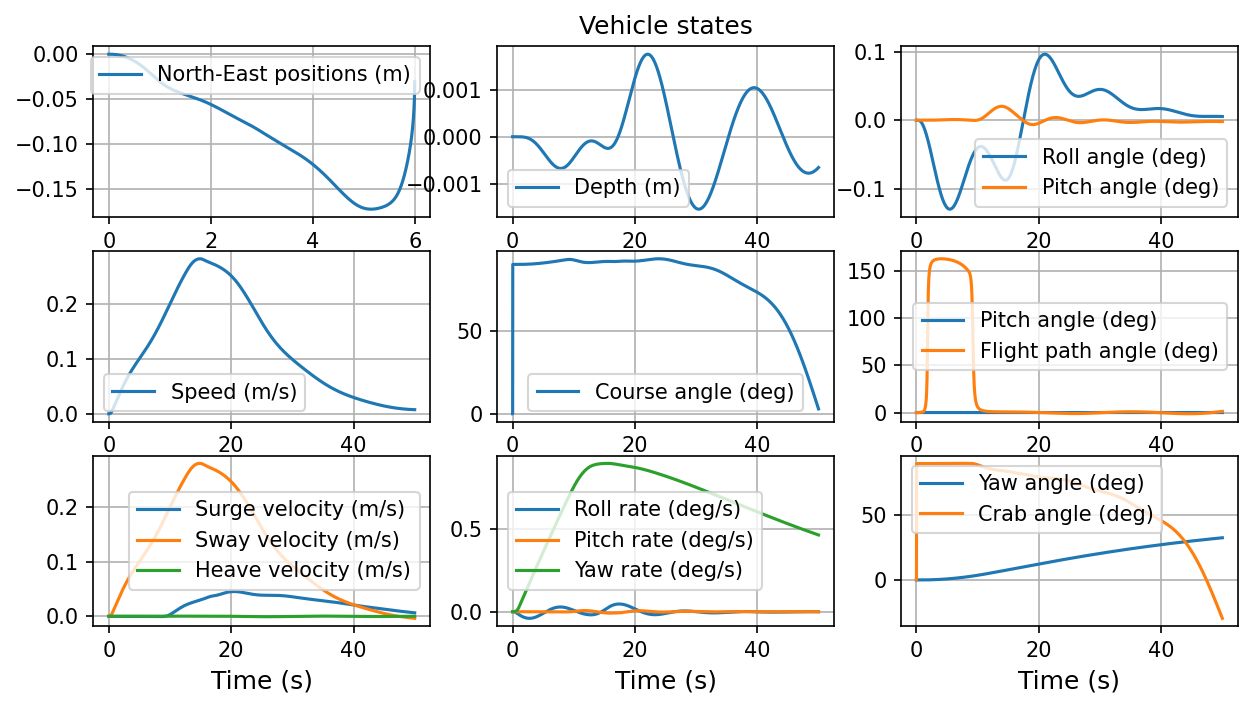

In [227]:
plotVehicleStates(simTime, simData, 3)

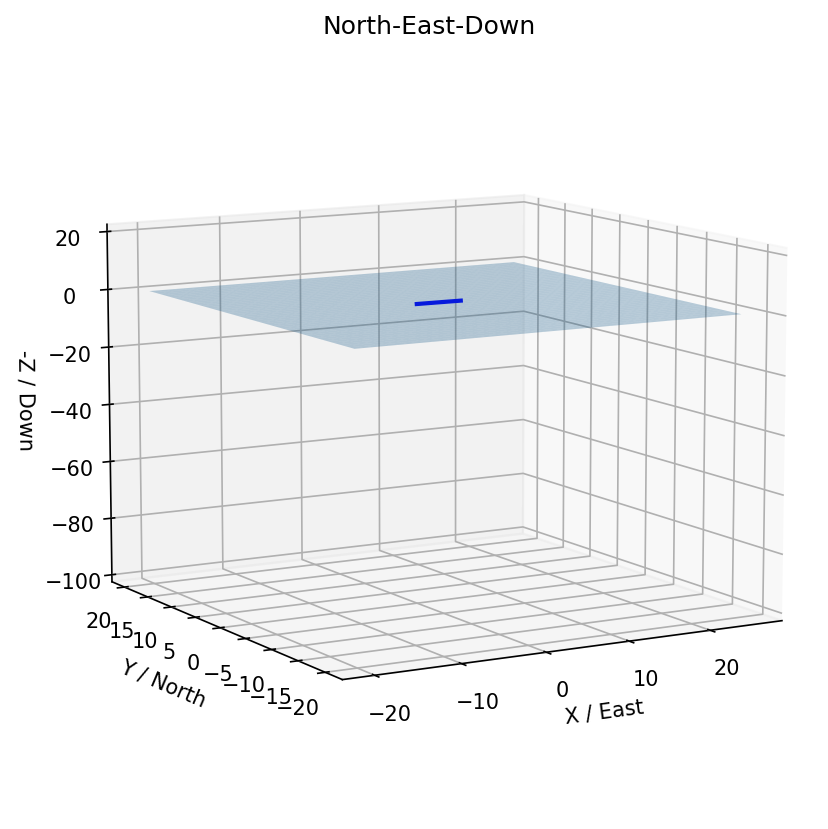

In [228]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [229]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [230]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [231]:
# Ws[0]*Ret[2]

In [232]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

In [233]:
idx=5/0.01

In [234]:
idx

500.0

In [235]:
ssa(simData[:, 3][int(idx)])

-0.0022313638346709297

In [236]:
ssa(simData[:, 4][int(idx)])

1.3587337935216937e-05

In [237]:
ssa(simData[:, 5][int(idx)])

0.013664356620045393

### Dynamics

In [473]:
def grayscott1d(t, Q): # here
    print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+5) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=9.81*1000
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(tau_force[:3])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret)
#     print(Z0)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)

    Z= (Z1 + Z2 +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
#                                              M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
#     print(lll)    
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho)
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [474]:
# import scipy

In [475]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [476]:
# us=ode15s.integrate(10)

In [477]:
tspan = (0., 2e-2)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0.0
1.2454056450483498e-14
2.4908112900966995e-13
3.7362169351450495e-13
9.963245160386798e-13
1.1070272400429776e-12
1.2454056450483498e-12
1.2454056450483498e-12
2.3266625198420595e-12
2.867290957238915e-12
5.57043314422319e-12
6.050991755242616e-12
6.651690019016899e-12
6.651690019016899e-12
1.1001576820319856e-11
1.3176520220971337e-11
2.405123722422873e-11
2.5984520247030044e-11
2.840112402553169e-11
2.840112402553169e-11
4.493339092046964e-11
5.319952436793861e-11
9.453019160528349e-11
1.0187786578081147e-10
1.1106245850022144e-10
1.1106245850022144e-10
1.726306632624741e-10
2.0341476564360044e-10
3.573352775492321e-10
3.846989241102333e-10
4.189034823114848e-10
4.189034823114848e-10
6.465844561516726e-10
7.604249430717665e-10
1.329627377672236e-09
1.4308189216012082e-09
1.5573083515124236e-09
1.5573083515124236e-09
2.395798571262993e-09
2.815043681138278e-09
4.911269230514702e-09
5.283931550403844e-09
5.7497594502652715e-09
5.7497594502652715e-09
8.831951485701553e-09
1.03730475

0.0007042592780201686
0.0007059381956295567
0.0007143327836764972
0.0007158251548848422
0.0007176906188952733
0.0007176906188952733
0.0007210484541140495
0.0007227273717234377
0.0007311219597703781
0.0007326143309787231
0.0007344797949891543
0.0007344797949891543
0.000738289966972053
0.0007401950529635024
0.0007497204829207492
0.0007514138926909264
0.000753530654903648
0.000753530654903648
0.000757482793371276
0.00075945886260509
0.0007693392087741599
0.0007710957147597724
0.0007732913472417879
0.0007732913472417879
0.0007768573724863105
0.0007786403851085718
0.0007875554482198784
0.0007891403483285552
0.000791121473464401
0.000791121473464401
0.0007764362904293874
0.0007780087620231871
0.0007858711199921858
0.0007872688725200078
0.0007890160631797853
0.0007890160631797853
0.0007921610063673848
0.0007937334779611845
0.0008015958359301833
0.0008029935884580052
0.0008047407791177827
0.0008047407791177827
0.0008085593204272903
0.000810468591082044
0.0008200149443558128
0.00082171207382670

0.0016000308069122448
0.0016081443066379081
0.0016095867065891373
0.0016113897065281736
0.0016113897065281736
0.0016151852199374215
0.0016170829766420454
0.0016265717601651652
0.0016282586550137197
0.001630367273574413
0.001630367273574413
0.0016343516300462442
0.00163634380828216
0.0016463046994617378
0.0016480755245603293
0.0016502890559335689
0.0016502890559335689
0.0016337131170446819
0.0016353860387798161
0.0016437506474554881
0.0016452376889978298
0.0016470964909257569
0.0016470964909257569
0.0016504423343960256
0.0016521152561311601
0.001660479864806832
0.0016619669063491736
0.0016638257082771007
0.0016638257082771007
0.0016676053175880112
0.0016694951222434667
0.0016789441455207432
0.0016806239718811478
0.0016827237548316537
0.0016827237548316537
0.0016865445923215747
0.0016884550110665352
0.0016980071047913376
0.001699705254786858
0.0017018279422812586
0.0017018279422812586
0.0016859611393403508
0.0016875798315946994
0.0016956732928664424
0.0016971121304258634
0.00169891067737

0.002445477009717037
0.002455194187114918
0.0024569216853189855
0.0024590810580740704
0.0024590810580740704
0.002463170908957349
0.0024652158343989876
0.0024754404616071832
0.0024772581731108624
0.0024795303124904616
0.0024795303124904616
0.0024623363946288555
0.002463964062906248
0.0024721024042932108
0.002473549220539782
0.002475357740847996
0.002475357740847996
0.002478613077402781
0.0024802407456801737
0.0024883790870671363
0.0024898259033137075
0.0024916344236219213
0.0024916344236219213
0.002495512529036831
0.002497451581744286
0.0025071468452815605
0.0025088704476881867
0.00251102495069647
0.00251102495069647
0.0025150143255042575
0.0025170090129081513
0.0025269824499276204
0.002528755505397748
0.002530971824735408
0.002530971824735408
0.0025142140876156876
0.0025158086560752965
0.002523781498373341
0.0025251988925596596
0.0025269706352925585
0.0025269706352925585
0.002530159772211776
0.002531754340671385
0.0025397271829694294
0.002541144577155748
0.002542916319888647
0.00254291

0.003269966235238504
0.0032798802140866106
0.003281642699215163
0.0032838458056258534
0.0032838458056258534
0.003288022724174256
0.003290111183448457
0.0033005534798194636
0.003302409888063198
0.003304730398367866
0.003304730398367866
0.0032870154690271
0.003288600300727723
0.00329652445923084
0.003297933198520283
0.0032996941226320865
0.0032996941226320865
0.003302863786033333
0.0033044486177339566
0.003312372776237073
0.003313781515526516
0.0033155424396383196
0.0033155424396383196
0.0033195075702681346
0.0033214901355830416
0.0033314029621575787
0.0033331652424374966
0.0033353680927873937
0.0033353680927873937
0.0033395080365131915
0.00334157800837609
0.0033519278676905845
0.003353767842679828
0.0033560678114163823
0.0033560678114163823
0.003338508831718306
0.003340079201183762
0.003347931048511043
0.003349326932480337
0.003351071787441955
0.003351071787441955
0.0033542125263728672
0.0033557828958383235
0.0033636347431656045
0.0033650306271348985
0.0033667754820965166
0.003366775482

0.004088246478797689
0.004090260560948271
0.0041003309717011814
0.0041021212669461425
0.004104359136002345
0.004104359136002345
0.004108612254933488
0.0041107388143990595
0.004121371611726916
0.004123261886807424
0.004125624730658059
0.004125624730658059
0.004107460164270468
0.00410901067840453
0.004116763249074839
0.004118141483860671
0.004119864277342962
0.004119864277342962
0.004122965305611085
0.004124515819745147
0.004132268390415456
0.004133646625201288
0.004135369418683579
0.004135369418683579
0.0041393981049431825
0.004141412448072985
0.004151484163721994
0.004153274690948484
0.004155512849981597
0.004155512849981597
0.004159756535487545
0.004161878378240518
0.004172487592005386
0.004174373674452473
0.004176731277511333
0.004176731277511333
0.004158603935357479
0.00416014947804542
0.004167877191485126
0.00416925100720774
0.004170968276861008
0.004170968276861008
0.00417405936223689
0.004175604904924831
0.004183332618364536
0.004184706434087151
0.004186423703740418
0.00418642370

0.004940811165466871
0.004922593804014733
0.0049241244425003465
0.004931777634928416
0.004933138202471184
0.004934838911899644
0.004934838911899644
0.0049379001888708715
0.004939430827356485
0.004947084019784555
0.004948444587327323
0.004950145296755783
0.004950145296755783
0.004954171048687532
0.004956183924653405
0.004966248304482777
0.004968037527563554
0.004970274056414526
0.004970274056414526
0.004974525318772064
0.004976650949950832
0.004987279105844677
0.004989168555781361
0.0049915303682022145
0.0049915303682022145
0.0049733319279616495
0.004974860863735211
0.004982505542603019
0.004983864596623963
0.004985563414150142
0.004985563414150142
0.004988621285697266
0.004990150221470827
0.004997794900338635
0.004999153954359579
0.0050008527718857585
0.0050008527718857585
0.005004866108314995
0.005006872776529614
0.005016906117602707
0.005018689822682367
0.0050209194540319435
0.0050209194540319435
0.0050252383460401145
0.0050273977920442
0.005038195022064627
0.005040114529623814
0.005

0.005745117066300922
0.005746647571650689
0.005754300098399526
0.005755660547599319
0.00575736110909906
0.00575736110909906
0.005761306013934624
0.005763278466352406
0.005773140728441314
0.005774894019479343
0.0057770856332768775
0.0057770856332768775
0.0057812281776481594
0.005783299449833801
0.005793655810762007
0.005795496941593687
0.005797798355133289
0.005797798355133289
0.005780122255359563
0.005781640566400906
0.005789232121607621
0.005790581731422147
0.005792268743690306
0.005792268743690306
0.0057953053657729915
0.005796823676814335
0.005804415232021049
0.005805764841835576
0.005807451854103735
0.005807451854103735
0.0058114028603211505
0.005813378363429859
0.0058232558789733995
0.0058250118817366955
0.005827206885190815
0.005827206885190815
0.005831387622306174
0.005833477990863853
0.00584392983365225
0.005845787939036854
0.005848110570767609
0.005848110570767609
0.005830260171507595
0.005831786814665985
0.005839420030457935
0.005840777046598726
0.005842473316774715
0.0058424

0.006563795024576402
0.006573669928276424
0.006575425466711984
0.006577619889756433
0.006577619889756433
0.00658178925943049
0.006583873944267519
0.0065942973684526614
0.006596150421641131
0.0065984667381267185
0.0065984667381267185
0.006580624781647874
0.006582127227593595
0.006589639457322197
0.006590974964829504
0.006592644349213638
0.006592644349213638
0.006595649241105079
0.006597151687050799
0.006604663916779402
0.006605999424286709
0.006607668808670843
0.006607668808670843
0.006611618619235652
0.0066135935245180575
0.006623468050930082
0.006625223522292219
0.006627417861494891
0.006627417861494891
0.006631594640153371
0.00663368302948261
0.006644124976128808
0.0066459813221992434
0.006648301754787288
0.006648301754787288
0.00663042530385461
0.006631929025034469
0.006639447630933767
0.006640784271982531
0.006642455073293486
0.006642455073293486
0.0066454625156532054
0.006646966236833064
0.006654484842732362
0.006655821483781126
0.006657492285092081
0.006657492285092081
0.00666143

0.00738459935880175
0.007386252478216009
0.007386252478216009
0.007389228093161675
0.007390715900634508
0.007398154937998673
0.0073994774335300805
0.007401130552944339
0.007401130552944339
0.007405051571135788
0.0074070120802315126
0.007416814625710135
0.00741855730046189
0.0074207356439015834
0.0074207356439015834
0.007424882136238558
0.007426955382407044
0.00743732161324948
0.007439164498732579
0.007441468105586454
0.007441468105586454
0.007423710374351633
0.007425197739576657
0.007432634565701781
0.007433956668124025
0.007435609296151831
0.007435609296151831
0.00743858402660188
0.007440071391826905
0.007447508217952028
0.007448830320374272
0.007450482948402078
0.007450482948402078
0.007454401661674896
0.007456361018311305
0.007466157801493349
0.007467899451836824
0.007470076514766167
0.007470076514766167
0.007474219236245659
0.007476290596985406
0.007486647400684135
0.007488488610230576
0.007490790122163627
0.007490790122163627
0.007473048417918904
0.007474534369495273
0.00748196412

0.008210616770551153
0.008212672054723499
0.008222948475585228
0.008224775394849535
0.008227059043929919
0.008227059043929919
0.00820944953990596
0.008210921208755708
0.008218279553004453
0.008219587703093119
0.008221222890703952
0.008221222890703952
0.00822416622840345
0.008225637897253198
0.008232996241501943
0.008234304391590608
0.008235939579201441
0.008235939579201441
0.00823982292530271
0.008241764598353343
0.008251472963606513
0.008253198895207078
0.008255356309707782
0.008255356309707782
0.008259464228462925
0.008261518187840496
0.00827178798472835
0.008273613726397303
0.008275895903483493
0.008275895903483493
0.008258297454657693
0.008259768027132647
0.008267120889507424
0.008268428065040717
0.008270062034457334
0.008270062034457334
0.008273003179407245
0.0082744737518822
0.008281826614256976
0.00828313378979027
0.008284767759206887
0.008284767759206887
0.008288648839791872
0.008290589380084366
0.008300292081546833
0.00830201700625127
0.008304173162131818
0.008304173162131818


0.008998788526530696
0.008998788526530696
0.009001698720284066
0.009003153817160752
0.009010429301544177
0.009011722720990118
0.009013339495297546
0.009013339495297546
0.009017184814925817
0.009019107474739952
0.00902872077381063
0.009030429804756528
0.009032566093438901
0.009032566093438901
0.009036636086069834
0.0090386710823853
0.00904884606396263
0.009050654949576378
0.009052916056593563
0.009052916056593563
0.009035474090535506
0.00903692808908381
0.00904419808182532
0.009045490524979367
0.009047106078921925
0.009047106078921925
0.00905001407601853
0.009051468074566832
0.009058738067308345
0.009060030510462391
0.00906164606440495
0.00906164606440495
0.009065488925360202
0.00906741035583783
0.009077017508225961
0.009078725446428295
0.009080860369181213
0.009080860369181213
0.00908492796586313
0.00908696176420409
0.009097130755908883
0.0090989385766564
0.0091011983525908
0.0091011983525908
0.009083766238328942
0.009085219172902807
0.009092483845772131
0.009093775343171122
0.00909538

In [ ]:
# key takeaway: one can calibrate the model by tuning bc(init) and force_schedule 

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)

# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()